# `AbsorptionModel` Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate the basic features of the `AbsorptionModel` model. `AbsorptionModel` models the 1612, 1665, 1667, and 1720 MHz hyperfine transitions of OH and predicts their absorption spectra: $1-\exp(-\tau)$.

In [1]:
# General imports    
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.1
amoeba2 version: 1.0.1+5.g20017af.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `AbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"absorption_1612", "absorption_1665", "absorption_1667", and "absorption_1720"`.

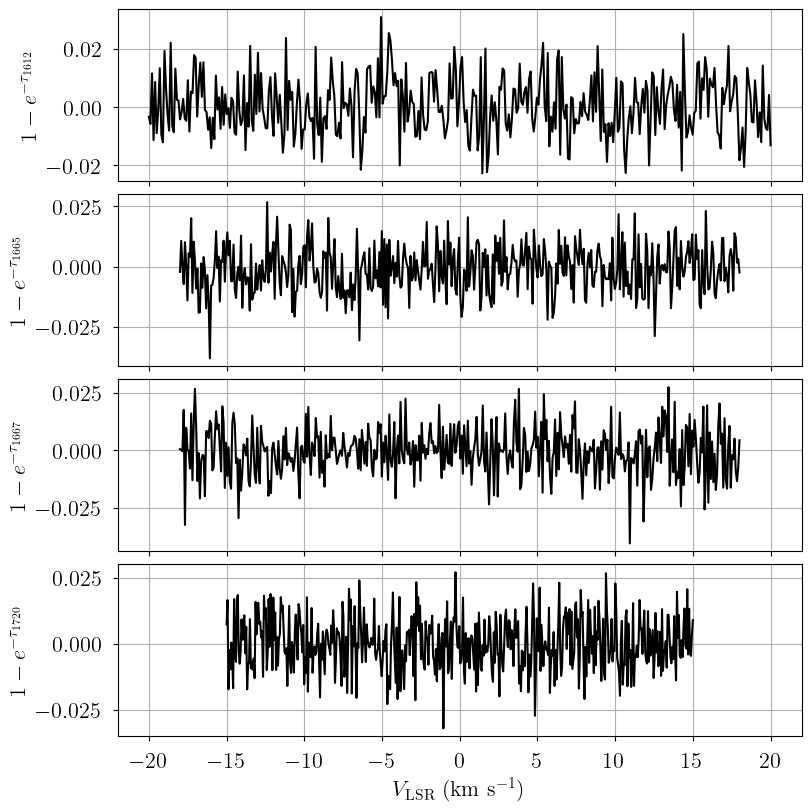

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_absorption = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}

# spectral data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
absorption = {label: rms_absorption[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

# TauModel expects four observations
dummy_data = {
    f"absorption_{label}": SpecData(
        velo_axis[label],
        absorption[label],
        rms_absorption[label],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$1 - e^{-\tau_{"+f"{label}"+r"}}$"
    )
    for label in velo_axis.keys()
}

# Plot dummy data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, dummy_datum in zip(axes, dummy_data.values()):
    ax.plot(dummy_datum.spectral, dummy_datum.brightness, "k-")
    ax.set_ylabel(dummy_datum.ylabel)
_ = axes[-1].set_xlabel(dummy_datum.xlabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from amoeba2 import AbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = AbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.0, 1.0], # mean and width of log10(N0) prior (cm-2)
    prior_log10_N_ratio = 0.1, # mean and width of log10(Nu/Nl) prior
    prior_log10_depth = [1.0, 1.0], # mean and width of log10(depth) prior (pc)
    prior_log10_Tkin = [2.0, 1.0], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_log10_nth_fwhm_1pc = [0.2, 0.1], # mean and width of non-thermal FWHM prior (km/s)
    prior_depth_nth_fwhm_power = [0.4, 0.1], # mean and width of non-thermal FWHM exponent prior
    prior_rms_absorption = 0.1, # width of absorption spectral rms prior
    ordered = False, # do not assume optically-thin
    mainline_pos_Tex = True, # force main line excitation temperatures to be positive
)
model.add_likelihood()

In [6]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_N0": np.array([12.75, 13.5, 13.0]),
    "log10_N1_N2_ratio": np.array([-0.21764, -0.21764, -0.21764892]),
    "log10_N0_N2_ratio": np.array([0.0043, 0.0043, 0.0043]),
    "log10_N1_N3_ratio": np.array([0.0043, 0.0043, 0.0043]),
    "log10_depth": np.array([0.0, 0.25, -0.25]),
    "log10_Tkin": np.array([1.25, 1.75, 1.0]),
    "velocity": np.array([-3.0, 1.0, 3.0]),
    "log10_nth_fwhm_1pc": 0.2,
    "depth_nth_fwhm_power": 0.3,
    "rms_absorption": np.array([0.01, 0.01, 0.01, 0.01]),
}

# Evaluate column density (cm-2; shape: transition, cloud)
log10_N = model.model["log10_N"].eval({k: sim_params[k] for k in sim_params.keys() if "log10_N" in k})
print("column densities (state, cloud):")
print(log10_N)

# Evaluate excitation temperature (K; shape: transition, cloud)
Tex = model.model["Tex"].eval({k: sim_params[k] for k in sim_params.keys() if "log10_N" in k})
print("excitation temperatures (transition, cloud):")
print(Tex)

data = {}
for i, label in enumerate(velo_axis.keys()):
    sim_params_label = sim_params.copy()
    sim_params_label[f"baseline_absorption_{label}_norm"] = np.array([0.0])
    sim_absorption = model.model[f"absorption_{label}"].eval(sim_params_label)
    data[f"absorption_{label}"] = SpecData(
        velo_axis[label],
        sim_absorption,
        sim_params["rms_absorption"][i],
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$1 - e^{-\tau_{"+f"{label}"+r"}}$"
    )

column densities (state, cloud):
[[12.75       13.5        13.        ]
 [12.52806    13.27806    12.77805108]
 [12.7457     13.4957     12.9957    ]
 [12.52376    13.27376    12.77375108]]
excitation temperatures (transition, cloud):
[[-0.07646039 -0.07646039 -0.07645884]
 [ 8.07249217  8.07249217  8.07249217]
 [ 8.08197905  8.08197905  8.08197905]
 [ 0.08003045  0.08003045  0.08002885]]


In [ ]:
# Plot data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [ ]:
# Initialize and define the model
model = AbsorptionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.0, 1.0], # mean and width of log10(N0) prior (cm-2)
    prior_log10_N_ratio = 0.1, # mean and width of log10(Nu/Nl) prior
    prior_log10_depth = [0.0, 0.25], # mean and width of log10(depth) prior (pc)
    prior_log10_Tkin = [2.0, 1.0], # mean and width of log10(Tkin) prior (K)
    prior_velocity = [0.0, 2.0], # mean and width of velocity prior (km/s)
    prior_log10_nth_fwhm_1pc = [0.2, 0.1], # mean and width of non-thermal FWHM prior (km/s)
    prior_depth_nth_fwhm_power = [0.4, 0.1], # mean and width of non-thermal FWHM exponent prior
    prior_rms_absorption = 0.01, # width of absorption spectral rms prior
    ordered = False, # do not assume optically-thin
    mainline_pos_Tex = True, # force main line excitation temperatures to be positive
)
model.add_likelihood()

In [ ]:
# Plot model graph
gviz = pymc.model_to_graphviz(model.model)
gviz.graph_attr["rankdir"] = "TB"
gviz.graph_attr["splines"] = "ortho"
# gviz.graph_attr["newrank"] = "true"
gviz.graph_attr["rank"] = "same"
gviz.graph_attr["ranksep"] = "1.0"
gviz.graph_attr["nodesep"] = "0.3"
gviz.render('absorption_model', format='png')
gviz

In [ ]:
# model string representation
print(model.model.str_repr())

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

In [ ]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
axes = plot_predictive(model.data, prior.prior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

We can also investigate the effect of our chosen priors on the deterministic quantities.

In [ ]:
from bayes_spec.plots import plot_pair

var_names = ["log10_N", "Tex", "fwhm_nonthermal", "log10_depth"]
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [ ]:
import time

start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

In [ ]:
az.summary(model.trace.posterior)

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

In [ ]:
model.solve()

Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [ ]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

In [ ]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
axes.ravel()[0].figure.set_size_inches(12, 20)
axes.ravel()[0].figure.tight_layout()

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

In [ ]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud. Also notice the tight correlation between column density and excitation temperature: optical depth spectra alone struggle to break this degeneracy!

In [ ]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(20, 20)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [ ]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

## Visualization using Mean Point Estimate

Here we demonstrate how to visualize the contribution of individual cloud components on the data from the mean posterior point estimates. Inspecting `predict_tau` in the model definition reveals how this works. Note that the mean posterior point estimate might not always be located within the posterior distribution (especially if there are strong parameter correlations)!

In [ ]:
# extract parameter mean point estimates
mean_point = model.trace.solution_0.mean(dim=["chain", "draw"])
mean_point

In [ ]:
from amoeba2 import physics

# evaluate line profile
line_profile = {}
for label in model.model.coords["component"]:
    line_profile[label] = physics.calc_line_profile(
        model.data[f"tau_{label}"].spectral,
        mean_point["velocity"].data,
        mean_point["fwhm"].data,
    ).eval()

# shape: spectral, clouds
print(line_profile["1612"].shape)

In [ ]:
# evaluate optical depth
tau = {}
for i, label in enumerate(model.model.coords["component"]):
    if label in ["1612", "1665"]:
        N_u = 10.0 ** mean_point["log10_N"].data[2]
    else:
        N_u = 10.0 ** mean_point["log10_N"].data[3]
    tau[label] = physics.calc_optical_depth(
        N_u,
        mean_point["inv_Tex"].data[i],
        line_profile[label],
        model.mol_data["freq"][i],
        model.mol_data["Aul"][i],
    ).eval()
    
# shape: spectral, clouds
print(tau["1612"].shape)

In [ ]:
# evaluate un-normalized baseline
baseline = {}
for i, label in enumerate(model.model.coords["component"]):
    baseline_norm = np.sum([
        mean_point[f"baseline_tau_{label}_norm"].data[j] / (j + 1.0)**j * model.data[f"tau_{label}"].spectral_norm**j
        for j in range(model.baseline_degree + 1)
    ], axis=0)
    baseline[label] = model.data[f"tau_{label}"].unnormalize_brightness(baseline_norm)
    
# shape: spectral
print(baseline['1612'].shape)

In [ ]:
# Plot cloud contributions over data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for i, label in enumerate(model.model.coords["component"]):
    axes[i].plot(model.data[f"tau_{label}"].spectral, model.data[f"tau_{label}"].brightness, "k-")
    for j in range(n_clouds):
        axes[i].plot(model.data[f"tau_{label}"].spectral, tau[label][:, j] + baseline[label], 'r-')
    # baseline
    axes[i].plot(model.data[f"tau_{label}"].spectral, baseline[label], 'b-')
    axes[i].set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)